In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import keras
import re
import cv2
import matplotlib.pyplot as plt
import os
import nltk
import string
import collections
from nltk.corpus import stopwords
import json
import pickle
from time import time
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, LSTM, Embedding
from keras.layers.merge import add

## Data Loading

In [2]:
# Read text captions
def readTextFile(path):
    with open(path) as f:
        captions=f.read()
    return captions

In [3]:
IMG_PATH="Flickr-8k/Flickr_Data/Flickr_Data/Images/"
TEXT_PATH="Flickr-8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt"

In [ ]:
captions=readTextFile(TEXT_PATH)
captions=captions.split('\n')[:-1] # Breaking captions into new line adn discarding last line which is empty
print(len(captions))

In [ ]:
captions

In [ ]:
# Dictionary to map each image with its caption
descriptions={}
for cap in captions:
    first, second=cap.split("\t")
    img_name=first.split(".")[0]
    
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
    descriptions[img_name].append(second)

In [ ]:
descriptions

['man and woman pose for the camera while another man looks on', 'man is holding the hand of woman up to his mouth in front of some buildings while another man looks on', 'multiracial couple posing for picture', 'asian man and blond woman holding hands outdoors man in background watches', 'guy in blue shirt biting hand of girl in black striped jacket while another guy watches']


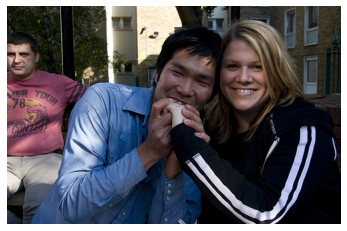

In [14]:
# Showing an image and its description
example_image="1042590306_95dea0916c"
print(descriptions[example_image])
img=cv2.imread(IMG_PATH+example_image+".jpg")
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

## Text cleaning

In [4]:
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+", " ", sentence) # Substituting anything that isn't an alphabet with space
    sentence=[s for s in sentence.split() if len(s)>1] # Removing single alphabet words(optional)
    sentence=" ".join(sentence)
    return sentence

In [ ]:
# Example
clean_text("A cat is sitting over house #64")

In [ ]:
# Cleaning all of the text
for key, caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i]=clean_text(caption_list[i])
descriptions

In [ ]:
descriptions[example_image]

In [ ]:
# Saving the cleaned captions in a text file
with open("Preprocessed data/cleaned_descriptions.txt", "w") as f:
    f.write(str(descriptions))

In [5]:
# Loading cleaned descriptions
descriptions=None
with open("Preprocessed data/cleaned_descriptions.txt", "r") as f:
    description_string=f.read()
    
json_acceptable_string=description_string.replace("'", "\"")
descriptions=json.loads(json_acceptable_string)
descriptions

{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
  'black dog and tri colored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young girl with p

In [15]:
descriptions[example_image]

['man and woman pose for the camera while another man looks on',
 'man is holding the hand of woman up to his mouth in front of some buildings while another man looks on',
 'multiracial couple posing for picture',
 'asian man and blond woman holding hands outdoors man in background watches',
 'guy in blue shirt biting hand of girl in black striped jacket while another guy watches']

## Building vocab and Filtering out unwanted words

In [6]:
# Vocab
vocab=set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
print("Vocab size: %d"%len(vocab))

Vocab size: 8424


In [7]:
# Total words in all of the sentences
total_words=[]
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print("Total words: %d"%len(total_words))

Total words: 373837


In [8]:
# To make a dictionary of words and their frequncies
counter=collections.Counter(total_words)
freq_count=dict(counter)
print(len(freq_count.keys()))
freq_count

8424


{'child': 1545,
 'in': 18987,
 'pink': 739,
 'dress': 348,
 'is': 9345,
 'climbing': 507,
 'up': 1302,
 'set': 109,
 'of': 6723,
 'stairs': 109,
 'an': 2432,
 'entry': 1,
 'way': 53,
 'girl': 3328,
 'going': 149,
 'into': 1074,
 'wooden': 284,
 'building': 511,
 'little': 1768,
 'playhouse': 6,
 'the': 18420,
 'to': 3176,
 'her': 1178,
 'cabin': 4,
 'black': 3848,
 'dog': 8138,
 'and': 8863,
 'spotted': 38,
 'are': 3505,
 'fighting': 133,
 'tri': 14,
 'colored': 221,
 'playing': 2008,
 'with': 7765,
 'each': 430,
 'other': 773,
 'on': 10746,
 'road': 398,
 'white': 3959,
 'brown': 2578,
 'spots': 29,
 'staring': 57,
 'at': 2916,
 'street': 944,
 'two': 5643,
 'dogs': 2125,
 'different': 46,
 'breeds': 5,
 'looking': 744,
 'pavement': 48,
 'moving': 41,
 'toward': 146,
 'covered': 372,
 'paint': 62,
 'sits': 577,
 'front': 1386,
 'painted': 64,
 'rainbow': 22,
 'hands': 246,
 'bowl': 30,
 'sitting': 1368,
 'large': 1237,
 'small': 1278,
 'grass': 1622,
 'plays': 526,
 'fingerpaints': 3,

In [9]:
# Sorting dictionary according to the frequency count
sorted_freq_count=sorted(freq_count.items(), reverse=True, key=lambda x:x[1])
sorted_freq_count

[('in', 18987),
 ('the', 18420),
 ('on', 10746),
 ('is', 9345),
 ('and', 8863),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7275),
 ('of', 6723),
 ('two', 5643),
 ('white', 3959),
 ('black', 3848),
 ('boy', 3581),
 ('are', 3505),
 ('woman', 3403),
 ('girl', 3328),
 ('to', 3176),
 ('wearing', 3062),
 ('at', 2916),
 ('people', 2887),
 ('water', 2790),
 ('red', 2691),
 ('young', 2630),
 ('brown', 2578),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2279),
 ('dogs', 2125),
 ('running', 2073),
 ('through', 2032),
 ('playing', 2008),
 ('while', 1968),
 ('shirt', 1962),
 ('down', 1843),
 ('standing', 1789),
 ('ball', 1783),
 ('little', 1768),
 ('grass', 1622),
 ('snow', 1547),
 ('child', 1545),
 ('person', 1542),
 ('jumping', 1473),
 ('over', 1415),
 ('three', 1389),
 ('front', 1386),
 ('sitting', 1368),
 ('holding', 1324),
 ('up', 1302),
 ('field', 1283),
 ('small', 1278),
 ('by', 1249),
 ('large', 1237),
 ('green', 1234),
 ('one', 1223),
 ('group', 1218),
 ('yellow', 1217),
 ('her', 1178),
 ('walk

In [10]:
# Filtering out words with freq less than 10
threshold=10
sorted_freq_count=[x for x in sorted_freq_count if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_count]
print(len(total_words))

1845


In [11]:
# Preparing train and test data
TRAIN_PATH="Flickr-8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt"
TEST_PATH="Flickr-8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt"
train_file_data=readTextFile(TRAIN_PATH)
test_file_data=readTextFile(TEST_PATH)
train_file_data

'2513260012_03d33305cf.jpg\n2903617548_d3e38d7f88.jpg\n3338291921_fe7ae0c8f8.jpg\n488416045_1c6d903fe0.jpg\n2644326817_8f45080b87.jpg\n218342358_1755a9cce1.jpg\n2501968935_02f2cd8079.jpg\n2699342860_5288e203ea.jpg\n2638369467_8fc251595b.jpg\n2926786902_815a99a154.jpg\n2851304910_b5721199bc.jpg\n3423802527_94bd2b23b0.jpg\n3356369156_074750c6cc.jpg\n2294598473_40637b5c04.jpg\n1191338263_a4fa073154.jpg\n2380765956_6313d8cae3.jpg\n3197891333_b1b0fd1702.jpg\n3119887967_271a097464.jpg\n2276499757_b44dc6f8ce.jpg\n2506892928_7e79bec613.jpg\n2187222896_c206d63396.jpg\n2826769554_85c90864c9.jpg\n3097196395_ec06075389.jpg\n3603116579_4a28a932e2.jpg\n3339263085_6db9fd0981.jpg\n2532262109_87429a2cae.jpg\n2076906555_c20dc082db.jpg\n2502007071_82a8c639cf.jpg\n3113769557_9edbb8275c.jpg\n3325974730_3ee192e4ff.jpg\n1655781989_b15ab4cbff.jpg\n1662261486_db967930de.jpg\n2410562803_56ec09f41c.jpg\n2469498117_b4543e1460.jpg\n69710415_5c2bfb1058.jpg\n3414734842_beb543f400.jpg\n3006217970_90b42e6b27.jpg\n2192

In [12]:
# Seperating images names about new lines and removing the extention ("jpg") from their names
train=[row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
print(train[:10])
test=[row.split(".")[0] for row in test_file_data.split("\n")[:-1]]
print(test[:10])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea', '2638369467_8fc251595b', '2926786902_815a99a154']
['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01', '2654514044_a70a6e2c21', '2339106348_2df90aa6a9', '256085101_2c2617c5d0', '280706862_14c30d734a', '3072172967_630e9c69d0']


In [16]:
# Adding start and end tokens in the captions
train_descriptions={}
start_token="<s> "
end_token=" <e>"

for img_id in train:
    train_descriptions[img_id]=[]
    for caption in descriptions[img_id]:
        caption_to_append=start_token+caption+end_token
        train_descriptions[img_id].append(caption_to_append)
train_descriptions[example_image]

['<s> man and woman pose for the camera while another man looks on <e>',
 '<s> man is holding the hand of woman up to his mouth in front of some buildings while another man looks on <e>',
 '<s> multiracial couple posing for picture <e>',
 '<s> asian man and blond woman holding hands outdoors man in background watches <e>',
 '<s> guy in blue shirt biting hand of girl in black striped jacket while another guy watches <e>']

## Image processing

In [17]:
# To remove error due to tensorflow backend
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [18]:
# Resnet model pretrained on imagenet
model=ResNet50(weights="imagenet", input_shape=(224, 224, 3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [19]:
model_new=Model(model.input, model.layers[-2].output)

In [20]:
# Image preprocessing
def preprocess_img(img):
    img=image.load_img(img, target_size=(224, 224))
    img=image.img_to_array(img)
    img=np.expand_dims(img, axis=0)
    img=preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


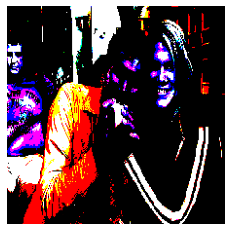

In [21]:
img=preprocess_img(IMG_PATH+example_image+".jpg")
plt.axis('off')
plt.imshow(img[0])
plt.show()

In [22]:
# Encoding images
def encode_image(img):
    img=preprocess_img(img)
    feature_vector=model_new.predict(img)
    feature_vector=feature_vector.reshape((-1, ))
    return feature_vector

In [23]:
example_feature_vector=encode_image(IMG_PATH+example_image+".jpg")
print(example_feature_vector.shape)
example_feature_vector

(2048,)


array([0.421939  , 1.8721704 , 0.2859682 , ..., 0.3712077 , 0.12453823,
       0.3284906 ], dtype=float32)

In [24]:
# Encoding all the images to respective feature vectors
start_time=time()
encoding_train, encoding_test={}, {}
print("Training images")
for ix, img_id in enumerate(train):
    img_path=IMG_PATH+img_id+".jpg"
    encoding_train[img_id]=encode_image(img_path)
    if ix%100==0:
        print("Encoding in process... (Time stamp %d)"%(ix))
print("Testing images")
for ix, img_id in enumerate(test):
    img_path=IMG_PATH+img_id+".jpg"
    encoding_test[img_id]=encode_image(img_path)
    if ix%100==0:
        print("Encoding in process... (Time stamp %d)"%(ix))
end_time=time()
print("Total time taken to encode the images:", end_time-start_time)

Training images
Encoding in process... (Time stamp 0)
Encoding in process... (Time stamp 100)
Encoding in process... (Time stamp 200)
Encoding in process... (Time stamp 300)
Encoding in process... (Time stamp 400)
Encoding in process... (Time stamp 500)
Encoding in process... (Time stamp 600)
Encoding in process... (Time stamp 700)
Encoding in process... (Time stamp 800)
Encoding in process... (Time stamp 900)
Encoding in process... (Time stamp 1000)
Encoding in process... (Time stamp 1100)
Encoding in process... (Time stamp 1200)
Encoding in process... (Time stamp 1300)
Encoding in process... (Time stamp 1400)
Encoding in process... (Time stamp 1500)
Encoding in process... (Time stamp 1600)
Encoding in process... (Time stamp 1700)
Encoding in process... (Time stamp 1800)
Encoding in process... (Time stamp 1900)
Encoding in process... (Time stamp 2000)
Encoding in process... (Time stamp 2100)
Encoding in process... (Time stamp 2200)
Encoding in process... (Time stamp 2300)
Encoding in 

In [25]:
# Storing encoded images to the disc
with open("Preprocessed data/encoded_train_features.pkl", "wb") as f:
    pickle.dump(encoding_train, f)
with open("Preprocessed data/encoded_test_features.pkl", "wb") as f:
    pickle.dump(encoding_test, f)

## Text preprocessing

In [26]:
with open("Preprocessed data/encoded_train_features.pkl", "rb") as f:
    encoding_train=pickle.load(f)
encoding_train

{'2513260012_03d33305cf': array([0.34707984, 0.51159215, 0.08728869, ..., 1.1897295 , 0.04043845,
        0.15271088], dtype=float32),
 '2903617548_d3e38d7f88': array([0.        , 0.0030779 , 0.09360094, ..., 0.43103486, 0.3798535 ,
        0.9165758 ], dtype=float32),
 '3338291921_fe7ae0c8f8': array([0.7674457 , 0.534227  , 0.3832514 , ..., 0.02098694, 0.18429354,
        0.04270015], dtype=float32),
 '488416045_1c6d903fe0': array([6.2481111e-01, 3.2965443e-01, 1.7834196e-04, ..., 1.2753806e+00,
        4.6392581e-01, 4.9036086e-01], dtype=float32),
 '2644326817_8f45080b87': array([0.11555304, 0.65965396, 0.0532331 , ..., 0.14397348, 1.0179366 ,
        0.0055659 ], dtype=float32),
 '218342358_1755a9cce1': array([1.7061825 , 0.40514785, 0.35206553, ..., 0.2940885 , 0.04833027,
        0.04654423], dtype=float32),
 '2501968935_02f2cd8079': array([0.10608288, 1.4420805 , 0.04447008, ..., 0.2058716 , 0.6978759 ,
        1.590432  ], dtype=float32),
 '2699342860_5288e203ea': array([0.4612

In [27]:
print(len(encoding_train[example_image]))
encoding_train[example_image]

2048


array([0.421939  , 1.8721704 , 0.2859682 , ..., 0.3712077 , 0.12453823,
       0.3284906 ], dtype=float32)

In [28]:
word_to_idx, idx_to_word={}, {}
for i, word in enumerate(total_words):
    word_to_idx[word]=i+1 # 0 is reserverd for all the words not in the vocab
    idx_to_word[i+1]=word

In [29]:
# Adding special words
initial_size=len(idx_to_word)
print("Initial vocab size:", initial_size)
idx_to_word[initial_size+1]="<s>"
word_to_idx["<s>"]=initial_size+1
idx_to_word[initial_size+2]="<e>"
word_to_idx["<e>"]=initial_size+2
final_size=len(idx_to_word)
print("Final vocab size:", final_size)

Initial vocab size: 1845
Final vocab size: 1847


In [30]:
# Setting batch length as the maximum length of any sentence
max_len=0
for key in train_descriptions.keys():
    for caption in train_descriptions[key]:
        max_len=max(max_len, len(caption.split()))
print(max_len)

35


## Custom Data Generator and Glove Embedding

In [31]:
# Custom data generator
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size):
    X1, X2, Y=[], [], []
    n=0
    while True:
        for key, desc_list in train_descriptions.items():
            n+=1
            photo=encoding_train[key]
            for desc in desc_list:
                seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1, len(seq)): # 0 is reserved as padding word
                    xi=seq[0:i]
                    yi=seq[i]
                    xi=pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0]
                    yi=to_categorical([yi], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(xi)
                    Y.append(yi)
                if n==batch_size:
                    yield ([np.array(X1), np.array(X2)], np.array(Y))
                    # when execution returns back here
                    n=0
                    X1, X2, Y=[], [], []

In [32]:
# Glove embedding
glove_path="C:/glove.6B.50d/glove.6B.50d.txt"
f=open(glove_path, encoding='utf-8')
embedding_index={}
for line in f:
    values=line.split()
    word=values[0]
    word_embedding=np.array(values[1: ], dtype='float')
    embedding_index[word]=word_embedding
f.close()

In [33]:
# Example of word embedding
emb_dim=len(embedding_index['apple'])
print(emb_dim)
embedding_index['apple']

50


array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [34]:
def get_embedding_matrix(vocab_size, emb_dim):
    matrix=np.zeros((vocab_size, emb_dim))
    for word, idx in word_to_idx.items():
        embedding_vector=embedding_index.get(word)
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
    return matrix

In [35]:
vocab_size=final_size+1 # vocab_size is total vocabulary length +1 because we append 0 as well for padding
embedding_matrix=get_embedding_matrix(vocab_size, emb_dim)
print(embedding_matrix.shape)

(1848, 50)


## Netural Network Model architecture

In [36]:
# Image feature as input
input_img_features=Input(shape=(2048, ))
inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256, activation='relu')(inp_img1)

In [37]:
# Caption as input
input_captions=Input(shape=(max_len, ))
inp_cap1=Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

In [38]:
# MLP
decoder1=add([inp_img2, inp_cap3])
decoder2=Dense(256, activation='relu')(decoder1)
outputs=Dense(vocab_size, activation='softmax')(decoder2)

In [39]:
# Combined model
model=Model(inputs=[input_img_features, input_captions], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [40]:
# Initializing the embedding layer with the embedding matrix and freezing it
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

## Training the model

In [41]:
epochs=40
batch_size=3
steps=len(train_descriptions)//batch_size

In [42]:
def train():
    for i in range(epochs):
        generator=data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size)
        model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        model.save("model_weights/model_"+str(i)+".h5") # Saving the model for each epoch

In [35]:
generator=data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size)

In [50]:
train()

c:\users\sanchit\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


2000/2000 [==============================] - 28s 14ms/step - loss: 2.4360


## Prediction and Inference

In [43]:
model.load_weights("model_weights/model_19.h5")

In [48]:
def predict_caption(photo):
    inp_text="<s>"
    for i in range(max_len):
        sequence=[word_to_idx[w] for w in inp_text.split() if w in word_to_idx]
        sequence=pad_sequences([sequence], maxlen=max_len, padding='post')
        ypred=model.predict([photo, sequence])
        ypred=ypred.argmax()
        word=idx_to_word[ypred]
        inp_text+=(" "+word)
        if word =='<e>':
            break
    final_caption=inp_text.split()[1: -1]
    final_caption=" ".join(final_caption)
    final_caption=final_caption.capitalize()+"."
    return final_caption

In [45]:
# Loading encoded test images
with open("Preprocessed data/encoded_test_features.pkl", "rb") as f:
    encoding_test=pickle.load(f)
encoding_test

{'3385593926_d3e9c21170': array([0.33316943, 0.38347825, 0.07253432, ..., 0.9083204 , 0.3560045 ,
        1.0914074 ], dtype=float32),
 '2677656448_6b7e7702af': array([0.29456154, 0.09500361, 0.70135504, ..., 0.01996764, 0.29111892,
        0.10959326], dtype=float32),
 '311146855_0b65fdb169': array([0.01133586, 0.08780424, 0.14325367, ..., 0.03005841, 1.1857142 ,
        0.06954556], dtype=float32),
 '1258913059_07c613f7ff': array([0.04770493, 1.4354494 , 0.10770179, ..., 0.13344465, 0.11505571,
        2.049624  ], dtype=float32),
 '241347760_d44c8d3a01': array([0.06552837, 6.682829  , 0.31763464, ..., 0.06200409, 0.03742879,
        0.04522503], dtype=float32),
 '2654514044_a70a6e2c21': array([1.9562044 , 0.04316769, 0.1114382 , ..., 0.02008325, 0.68325526,
        0.43294072], dtype=float32),
 '2339106348_2df90aa6a9': array([0.08876387, 1.1927911 , 0.07676466, ..., 0.01899938, 0.13417575,
        0.13799465], dtype=float32),
 '256085101_2c2617c5d0': array([0.61918086, 0.590477  , 0

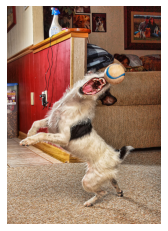

Dog is jumping on couch.


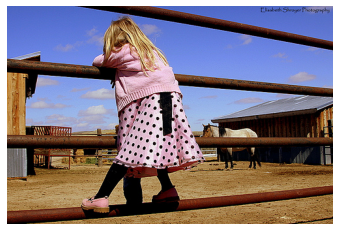

Girl in dress is jumping on trampoline.


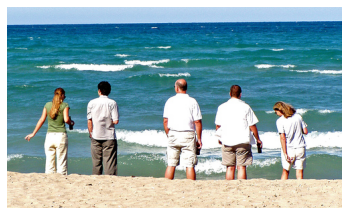

Two girls are playing in fountain.


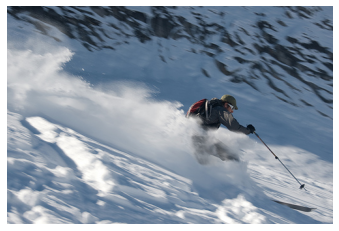

Man in red coat is skiing down snowy hill.


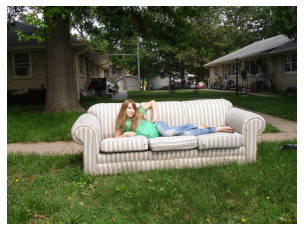

Woman in red shirt is jumping over hurdle.


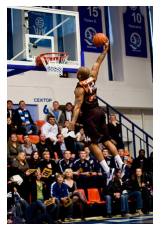

Crowd of people are playing cricket game in the air.


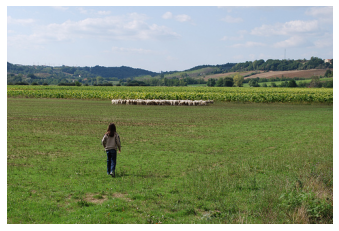

Two people fly kite in field.


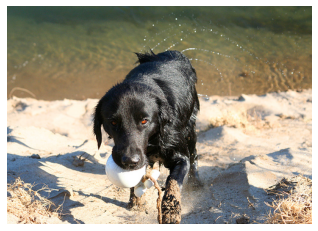

Black and tan dog is running through the water.


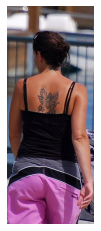

Little girl in pigtails dress and sandals is holding hands.


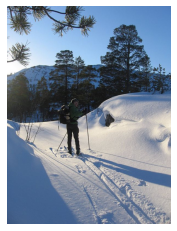

Skier is throwing snow in tire.


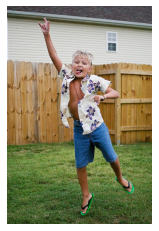

Boy in blue shirt is jumping up to catch ball.


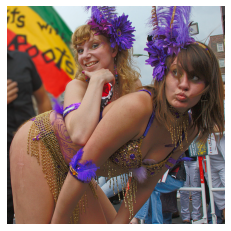

Woman in pink shirt is talking to woman in pink shirt.


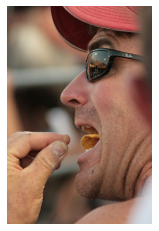

Young boy wearing hat and hair is wearing sunglasses.


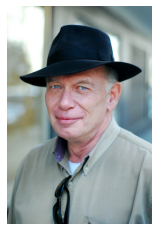

Man wearing glasses and sunglasses smiles for the camera.


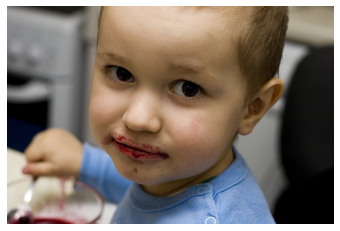

Little boy with his face painted is eye with hair.


In [51]:
# Picking random images and seeing the results
all_img_names=list(encoding_test.keys())
for i in range(15):
    idx=np.random.randint(0, 1000)
    img_name=all_img_names[idx]
    # Reshaping encoding _test from (2048, ) to (2048, 1) and saving in photo encoded
    photo_encoded=encoding_test[img_name].reshape((1, encoding_test[img_name].shape[0]))
    img=plt.imread("Flickr-8k/Flickr_Data/Flickr_Data/Images/"+img_name+".jpg")
    caption=predict_caption(photo_encoded)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    print(caption)

To improve the model further we can use a larger data set and a more complex neural network.